## Baseline erstellen

Für die Erstellung einer Baseline wird ein Klassifikator für die Klassifikationsaufgabe des Beispiel Titanic erstellt, mit dem transformierten Trainingsdatenset trainiert und dem transformierten Validierungsdatenset validiert.

Pakete importieren

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from treeinterpreter import treeinterpreter

Transformierte Daten laden

In [2]:
with open('../output/titanic/datasets_transformed.pkl', 'rb') as handle:
    datasets_transformed = pickle.load(handle)

### Machine Learning Verfahren anwenden

Als Klassifikator wird der K-Nearest Neighbors Algorithmus verwendet. Die Implementierung ist wie folgt:

In [3]:
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#classifier = KNeighborsClassifier(n_neighbors=3)
#classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = DecisionTreeClassifier()
classifier.fit(datasets_transformed['X_train'], datasets_transformed['y_train'])

DecisionTreeClassifier()

Nach importieren der KNeighborsClassifier-Klasse, wird eine Instanz erstellt und der Klassifikator mit den transformierten Daten trainiert.

In [4]:
classifier.score(datasets_transformed['X_val'], datasets_transformed['y_val'])

0.7569060773480663

In [5]:
classifier.score(datasets_transformed['X_test'], datasets_transformed['y_test'])

0.7527472527472527

Validiert wird durch aufrufen der score()-Methode und übergeben des Validierungsdatenset.

Das übliche Vorgehen beim Machine Learning ist **experimentell**. Man entwickelt zunächst eine Variante und erhält ein Ergebnis. In unserem Fall ein Accuracy Score von 0.74, bedeutet 74% der vorgehergesagten Werte sind richtig. Dieser Score dient als Basis für weitere Optimierungen. Es werden Veränderungen unterschiedlichster Art vorgenommen wie zum Beispiel 
* Anwendung weiterer Transformationsschritte
* Entfernen von Transformationsschritte
* Änderung der Transformationseinstellungen
* Hinzufügen von Merkmalen
* Entfernen von Merkmalen
* Modifizieren von Merkmalen
* Ändern des Machine Learning Algorithmus 
* Ändern der Hyperparameter

Nach **jeder Änderung** wird **geprüft** ob sich das Ergebnis, der Score, **verbessert oder verschlechtert** hat und entprechend die Änderung beibehalten oder verworfen. Häufig sind es sehr viele Experimente die durchgeführt werden müssen. Es fällt schwer den Überblick zu behalten und es ist aufwendig die Experimente manuell durchzuführen. Für die Automatisierung der Experimente für Hyperparameter kann die sogenannte **Grid-Search**[^footnote3] eingesetzt werden. Man gibt für jeden Hyperparamter eine begrenzte Menge von möglichen Werten die getestet werden soll. Grid-Search **testet alle Kombinationen und gibt die Wertekombination mit den besten Ergebnisen aus**.

Wie bereits zu Beginn dieses Abschnitts erwähnt, ist es möglich am Ende der Pipeline einen beliebigen Estimator einzusetzen anstatt ein Transformer. Ein beliebiger Estimator kann auch ein Predictor sein. So kann beim Anwendungsbeispiel Titanic einfach der Klassifikator am Ende der Pipeline eingefügt werden. Einer der Vorteile, wenn man die Vorverarbeitungsschritte und den Prediktor in einer Pipeline integriert ist, dass **Grid-Search auch für die Vorverarbeitungsschritte** eingesetzt werden kann.

Transformer Pipeline laden

In [6]:
with open('../output/titanic/transformer_pipeline.pkl', 'rb') as handle:
    transformer_pipeline = pickle.load(handle)

Datensets laden

In [7]:
with open('../output/titanic/datasets.pkl', 'rb') as handle:
    datasets = pickle.load(handle)

### Klassifikator in eine Pipeline integrieren

Erstellt wird eine Pipeline, die im ersten Schritt die bereits erstellte Transformer-Pipeline enthält und im Anschluss den Klassifikator.

```{figure} ../images/pipelineFull.png
---
height: 180px
align: center
name: fig-pipelineFull
---
```

In [8]:
full_pipeline = Pipeline(steps=[
    ('transformers', transformer_pipeline),
    ('predictor', DecisionTreeClassifier())
])

Die Pipeline wird mit dem Trainingsdatenset trainiert und dem Validierungsset validiert.

In [9]:
full_pipeline.fit(datasets['X_train'], datasets['y_train'])
full_pipeline.score(datasets['X_val'], datasets['y_val'])

0.7624309392265194

In [10]:
full_pipeline.score(datasets['X_test'], datasets['y_test'])

0.7692307692307693

Das Ergebnis ist wie erwartet unverändert. Die Accuracy beträgt 0.74. Nun können mit der Grid Search Methode optimale Einstellungen gefunden werden.

## Parameter optimieren

### Grid Search anwenden

Für jeden beliebigen Schritt in der Pipeline können Wertebereiche für die Parameter angegeben werden. Für das Anwendungsbeispiel werden folgende Wertebereiche gesetzt:
* der Faktor, der bei der IQR-Methode zur Ausreißererkennung verwendet wird, mit einem Wertebereich von [1.0, 1.5, 2.0, 3.0]
* der n_neighbors Parameter, der beim K-Nearest-Neighbor-Algorithmus bestimmt wie viele Nachbarn berücksichtigt werden, mit einem Wertebereich von [2, 3, 4, 5, 6, 7, 8]

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    #'transformers__num__outlier_remover__factor': [1.0, 1.5, 2.0, 3.0],
    'predictor__max_depth': [2,3,4],
    'predictor__min_samples_split' : [ 2,3,4,5,6,7], 
    'predictor__min_samples_leaf': [1,2,5,10,20,30,40,50,60,70,80,90,100]
}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=10)

Die Fit()-Methode testet alle Kombinationsmöglichkeiten und speichert die beste Parameterkombination im Attribut best_params_.

In [12]:
grid_search.fit(datasets['X_train'], datasets['y_train'])
grid_search.best_params_

KeyboardInterrupt: 

Die beste Parameterkombination kann nach dem Trainieren über das Atrribut 'best_params_' abgefragt werden.

In [13]:
grid_search.best_params_

{'predictor__max_depth': 3,
 'predictor__min_samples_leaf': 20,
 'predictor__min_samples_split': 2}

Über das Attribut best_score_ erhält man die Accuracy-Score der besten Parametereinstellung.

In [14]:
grid_search.best_score_

0.8107267645003494

Das Ergebnis auf den Validierungsdaten:

In [15]:
grid_search.score(datasets['X_val'], datasets['y_val'])

0.7415730337078652

Das Ergebnis hat sich im Vergleich zur vorherigen Einstellung, der Baseline, um 6% verbessert.

```{figure} ../images/gridSearch.png
---
height: 250px
align: center
name: fig-gridSearch
---
```

Ersetzten der bisherigen Pipeline mit der besten Pipeline aus Grid Search.

In [16]:
best_pipeline = grid_search.best_estimator_

Zum Abschluss: Validieren der Pipeline mit dem Validierungsset. Das Ergebnis liefert wie erwartet den Accuracy Score von 0.803

In [17]:
best_pipeline.score(datasets['X_val'], datasets['y_val'])

0.7415730337078652

## Merkmale optimieren

### Wichtige Merkmale erkennen

In [18]:
df_temp = datasets['X_train'].copy()
#df_temp = df_temp[features_numerical]
df_temp['Survived'] = datasets['y_train'].values

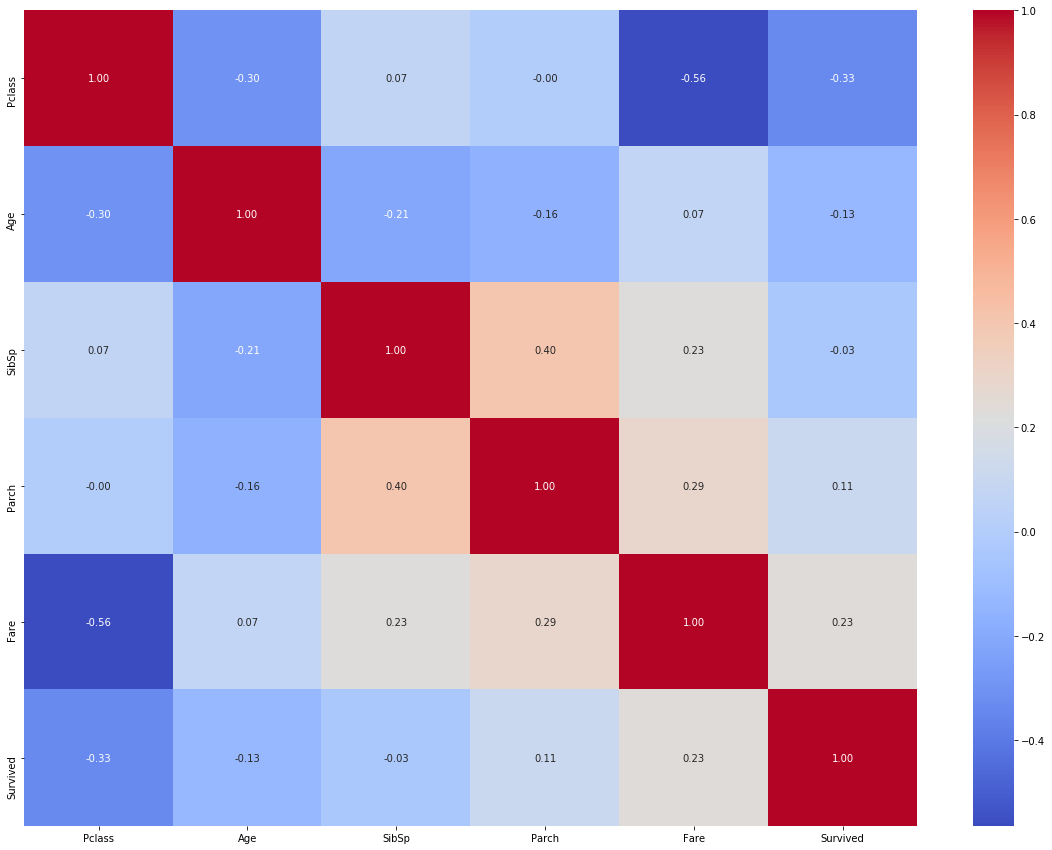

In [19]:
plt.subplots(figsize=(20,15))
sns.heatmap(df_temp.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

- Signifikante Korrelationen mit der Zielgröße "Survived"
* Sex_female(-0.55) und Sex_male (0.55)
* Pclass_3 (0.32) und Pclass_1(0.28)
* Fare (0.23)

- Sex_male und Sex_female -> 1.0 da Merkmale aus einem kategorischen Merkmal mit zwei Klassen erstellt worden sind 
- Pclass_1 und Fare -> 0.61 da für die erste Klasse sehr hohe Ticketpreise bezahlt wurden
- Parch und SibSp -> Geschwister oder Ehepartner an Bord oft mit Familie, daher Korrelation mit Eltern oder/und Kinder

/Users/alandmesser/anaconda3/envs/workshops/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/alandmesser/anaconda3/envs/workshops/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


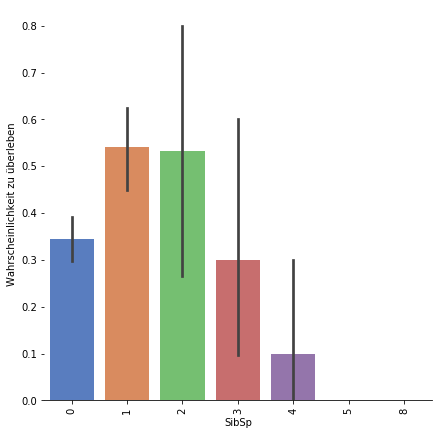

In [20]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=df_temp, kind="bar", size=6, palette = "muted")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Wahrscheinlichkeit zu überleben")

/Users/alandmesser/anaconda3/envs/workshops/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/alandmesser/anaconda3/envs/workshops/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


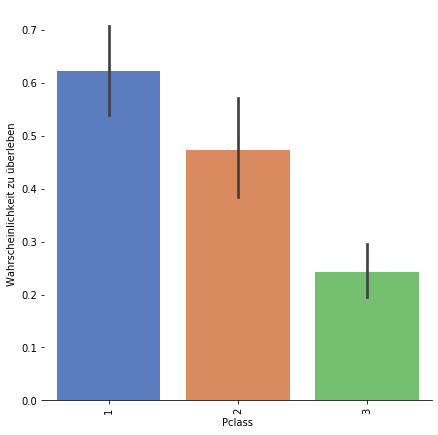

In [21]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=df_temp, kind="bar", size=6, palette = "muted")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Wahrscheinlichkeit zu überleben")

-> hohe Werte (viele Geschwister oder/und Ehepartner an Bord) führen zu einer geringeren Wahrscheinlichkeit zu überleben. Niedrige Werte -> geringe Überlebenswahrscheinlichkeit
-> Was ist hier der Hintergrund? Es liegt nahe, dass Passagiere nur gemeinsam mit den Familienangehörigen das Schiff verlassen wollten. Annahme: Je größer die Familie umso schwieriger ein Rettungsboot zu finden. Ist eine Person allein an Bord, war es zwar einfacher einen Platz im Rettungsboot zu finden, jedoch der Weg dorthin musste allein ohne Hilfe erfolgen.


/Users/alandmesser/anaconda3/envs/workshops/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/alandmesser/anaconda3/envs/workshops/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


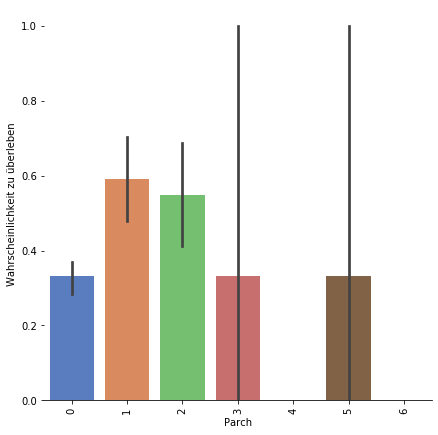

In [22]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="Parch",y="Survived",data=df_temp, kind="bar", size=6, palette = "muted")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Wahrscheinlichkeit zu überleben")

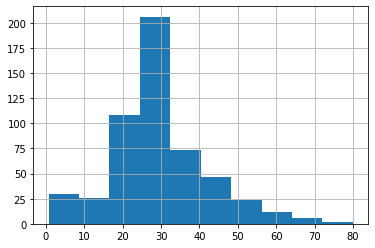

In [23]:
df_temp['Age'].hist()

In [24]:
bins = [0,10, 18, 50, 100]
labels = [1,2,3,4]
df_temp['Age_binned'] = pd.cut(df_temp['Age'], bins=bins, labels=labels)
print(df_temp)

     Pclass     Sex   Age  SibSp  Parch      Fare Embarked  Survived  \
109       3  female  28.0      1      0   24.1500        Q         1   
391       3    male  21.0      0      0    7.7958        S         1   
6         1    male  54.0      0      0   51.8625        S         0   
405       2    male  34.0      1      0   21.0000        S         0   
291       1  female  19.0      1      0   91.0792        C         1   
..      ...     ...   ...    ...    ...       ...      ...       ...   
79        3  female  30.0      0      0   12.4750        S         1   
527       1    male  28.0      0      0  221.7792        S         0   
536       1    male  45.0      0      0   26.5500        S         0   
742       1  female  21.0      2      2  262.3750        C         1   
144       2    male  18.0      0      0   11.5000        S         0   

    Age_binned  
109          3  
391          3  
6            4  
405          3  
291          3  
..         ...  
79           3  

/Users/alandmesser/anaconda3/envs/workshops/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/alandmesser/anaconda3/envs/workshops/lib/python3.7/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


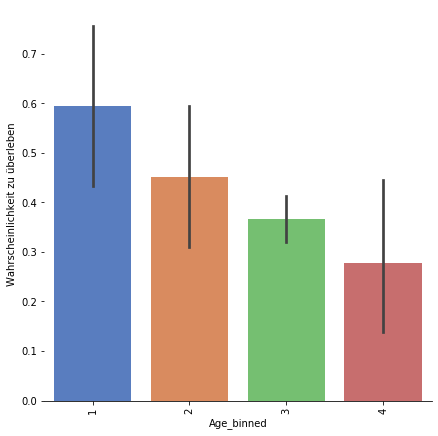

In [25]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="Age_binned",y="Survived",data=df_temp, kind="bar", size=6, palette = "muted")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Wahrscheinlichkeit zu überleben")

In [26]:
df_temp.tail(-20)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,Age_binned
710,1,female,24.0,0,0,49.5042,C,1,3
139,1,male,24.0,0,0,79.2000,C,0,3
265,2,male,36.0,0,0,10.5000,S,0,3
322,2,female,30.0,0,0,12.3500,Q,1,3
747,2,female,30.0,0,0,13.0000,S,1,3
...,...,...,...,...,...,...,...,...,...
79,3,female,30.0,0,0,12.4750,S,1,3
527,1,male,28.0,0,0,221.7792,S,0,3
536,1,male,45.0,0,0,26.5500,S,0,3
742,1,female,21.0,2,2,262.3750,C,1,3


In [27]:
df_temp.corr()

,Pclass,Age,SibSp,Parch,Fare,Survived
Pclass,1.000000,-0.296528,0.066529,-0.000601,-0.564594,-0.332667
Age,-0.296528,1.000000,-0.211573,-0.164517,0.071345,-0.127745
SibSp,0.066529,-0.211573,1.000000,0.401846,0.225998,-0.033341
Parch,-0.000601,-0.164517,0.401846,1.000000,0.287679,0.107890
Fare,-0.564594,0.071345,0.225998,0.287679,1.000000,0.231076
Survived,-0.332667,-0.127745,-0.033341,0.107890,0.231076,1.000000


In [28]:
df_temp.corr()['Survived']

Pclass     -0.332667
Age        -0.127745
SibSp      -0.033341
Parch       0.107890
Fare        0.231076
Survived    1.000000
Name: Survived, dtype: float64

### Neue Merkmale hinzufügen

In [29]:
#%%writefile transformer_family.py

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

age_ix, sibsp_ix, parch_ix = 0, 1, 2

class FamilySize(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = pd.DataFrame(X)
        X_["FamilySize"] = X_.iloc[:,sibsp_ix] + X_.iloc[:,parch_ix] + 1
        X_['Single'] = X_['FamilySize'].map(lambda s: 1 if s == 1 else 0)
        #X_['SmallF'] = X_['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
        #X_['MedF'] = X_['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
        #X_['LargeF'] = X_['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
        #self.feature_names.extend(['FamilySize', 'Single', 'SmallF', 'MedF', 'LargeF'])
        self.feature_names.extend(['FamilySize', 'Single'])
        return X_.values
    
    def get_feature_names(self):
        return self.feature_names
    
class AgeBinned(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = pd.DataFrame(X)
        bins = [0, 1, 10, 100]
        labels = [1,2,3]
        print('xxxxxxxxxxxx')
        print(X_)
        X_[age_ix] = pd.cut(X_[age_ix], bins=bins, labels=labels)
        return X_.values
    

In [30]:
#from transformer_family import FamilySize
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from transformer import OutlierRemover

In [31]:
features_numerical = ['Age', 'SibSp', 'Parch', 'Fare']
features_categorical = ['Pclass', 'Sex', 'Embarked']

pipe_numerical = Pipeline(steps=[
    ('outlier_remover', OutlierRemover(factor=1.0)),
    #('familysize', FamilySize(feature_names=features_numerical)),
    ('agebinned', AgeBinned())
    #('scaler', StandardScaler())
])

pipe_categorical = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary'))
])

transformer_pipe = ColumnTransformer(
    transformers = [
        (
            'num', 
            pipe_numerical,
            features_numerical
        ),
        (
            'cat',
            pipe_categorical,
            features_categorical
        )
    ])

full_pipe = Pipeline(steps=[
    ('transformers', transformer_pipe),
    ('predictor', DecisionTreeClassifier(
        max_depth=3, 
        random_state=0,
        min_samples_leaf=30,
        min_samples_split=2
    ))
])

In [32]:
features_numerical

['Age', 'SibSp', 'Parch', 'Fare']

In [33]:
transformer_pipe.fit_transform(datasets['X_train'])[:5]

xxxxxxxxxxxx
        0    1    2        3
0    28.0  1.0  0.0  24.1500
1    21.0  0.0  0.0   7.7958
2    28.0  0.0  0.0  51.8625
3    34.0  1.0  0.0  21.0000
4    19.0  1.0  0.0  12.3500
..    ...  ...  ...      ...
529  30.0  0.0  0.0  12.4750
530  28.0  0.0  0.0  12.3500
531  45.0  0.0  0.0  26.5500
532  21.0  2.0  0.0  12.3500
533  18.0  0.0  0.0  11.5000

[534 rows x 4 columns]


array([[3, 1.0, 0.0, 24.15, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
       [3, 0.0, 0.0, 7.7958, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0],
       [3, 0.0, 0.0, 51.8625, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
       [3, 1.0, 0.0, 21.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0],
       [3, 1.0, 0.0, 12.35, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]],
      dtype=object)

In [35]:
features_categorical_transformed = list(transformer_pipe.transformers_[1][1]['onehot'].get_feature_names(features_categorical))

features_numerical_transformed = transformer_pipe.transformers_[0][1]['familysize'].get_feature_names()

feature_names = features_numerical_transformed + features_categorical_transformed

In [37]:
full_pipe.fit(datasets['X_train'], datasets['y_train'])
full_pipe.score(datasets['X_val'], datasets['y_val'])

xxxxxxxxxxxx
        0    1    2        3
0    28.0  1.0  0.0  24.1500
1    21.0  0.0  0.0   7.7958
2    28.0  0.0  0.0  51.8625
3    34.0  1.0  0.0  21.0000
4    19.0  1.0  0.0  12.3500
..    ...  ...  ...      ...
529  30.0  0.0  0.0  12.4750
530  28.0  0.0  0.0  12.3500
531  45.0  0.0  0.0  26.5500
532  21.0  2.0  0.0  12.3500
533  18.0  0.0  0.0  11.5000

[534 rows x 4 columns]
xxxxxxxxxxxx
        0    1    2         3
0    38.0  1.0  0.0  14.05415
1    24.0  0.0  0.0   8.85000
2    28.0  0.0  0.0  14.05415
3     9.0  2.0  0.0  34.37500
4    32.0  0.0  0.0   7.92500
..    ...  ...  ...       ...
173  28.0  0.0  0.0  21.07500
174  28.0  0.0  0.0  14.05415
175  28.0  2.0  0.0  19.25830
176  34.0  0.0  0.0  13.00000
177  28.0  0.0  0.0  35.50000

[178 rows x 4 columns]


0.7752808988764045

In [38]:
full_pipe.score(datasets['X_test'], datasets['y_test'])

xxxxxxxxxxxx
        0    1    2        3
0    28.0  0.0  0.0  13.5000
1    28.0  0.0  0.0   9.2250
2    28.0  0.0  0.0   0.0000
3    18.0  0.0  0.0   9.2250
4    25.0  0.0  0.0   7.6500
..    ...  ...  ...      ...
174  28.0  0.0  0.0   7.7500
175  28.0  0.0  0.0  24.1500
176  28.0  0.0  0.0  13.0000
177  28.0  0.0  0.0   7.7500
178  28.0  0.0  0.0  25.4667

[179 rows x 4 columns]


0.8435754189944135

In [39]:
clf = full_pipeline.named_steps['predictor']

In [ ]:
importances = clf.feature_importances_
importances

In [ ]:
importances = pd.Series(importances, index=feature_names)
importances.sort_values(ascending=False)

In [ ]:
importances_filtered = importances[importances <= 0.02]
features_notrelevant = list(importances_filtered.index)
features_notrelevant

In [ ]:
X_val_transformed = transformer_pipeline.fit_transform(datasets['X_val'])

In [ ]:
dfv = pd.DataFrame(X_val_transformed, columns=feature_names)
dfv

In [ ]:
dfv = dfv.drop(features_notrelevant, axis=1)

In [ ]:
X_train_transformed = transformer_pipeline.fit_transform(datasets['X_train'])

In [ ]:
df = pd.DataFrame(X_train_transformed, columns=feature_names)
df

In [ ]:
dft = df.drop(features_notrelevant, axis=1)

In [ ]:
classifier = DecisionTreeClassifier()
classifier.fit(dft, datasets_transformed['y_train'])

In [ ]:
classifier.score(dfv, datasets_transformed['y_val'])

In [ ]:
importances.plot.bar()

In [ ]:
predictions, bias, contributions = treeinterpreter.predict(clf, X_val_transformed)

In [ ]:
classes = np.unique(datasets['y_val'])
for pred, contr in zip(predictions, contributions):
    df_pred  = pd.DataFrame(pred, columns=['pred_value']).nlargest(3,'pred_value')
    df_pred = df_pred.assign(pred_name= np.array(classes)[df_pred.index.values.tolist()])
df_pred

In [ ]:
X_val_t_df = pd.DataFrame(X_val_transformed, columns=feature_names)
X_val_t_df['FamilySize'].hist()

In [ ]:
datasets['y_val']

In [ ]:
features_categorical_transformed

In [ ]:
df_label = datasets['y_val'].copy()
df_label.reset_index(drop=True, inplace=True)
columns = [
    'pred1_name',
    'pred1_value', 
    'pred2_name',
    'pred2_value',
    'pred1_1st_name', 
    'pred1_1st_value', 
    'pred1_2nd_name', 
    'pred1_2nd_value',
    'pred1_3rd_name', 
    'pred1_3rd_value'
]
l = []
for pred, contr in zip(predictions, contributions):
    df_pred  = pd.DataFrame(pred, columns=['pred_value']).nlargest(3,'pred_value')
    
    df_pred = df_pred.assign(pred_name= np.array(classes)[df_pred.index.values.tolist()])
    pred_max = pred.max()
    pred_idx = pred.argmax()
    df_contr = pd.DataFrame(contr)

    df_contr = df_contr.abs()
    df_contr['feature'] = features_numerical_transformed + features_categorical_transformed
    df_impact = df_contr.nlargest(3,pred_idx)

    dfp = df_pred[['pred_name', 'pred_value']]
    dfi = df_impact[['feature',pred_idx]]
    l.append(dfp.values.flatten().tolist() + dfi.values.flatten().tolist())

df_interpret = pd.DataFrame(l, columns=columns)
df_interpret.insert(0,'truelabel', df_label)

df_interpret

In [ ]:
def plotHistograms(column_group, column_count, prefix, color):
    grps = df_interpret.groupby(column_group)
    for name, gr in grps:
        print(name)
        plt.figure()        
        ax = gr[column_count].value_counts().plot(kind='bar', color=color)
        plt.show()

In [ ]:
plotHistograms(
    column_group = 'pred1_name', 
    column_count = 'pred1_1st_name', 
    prefix = '_1', 
    color = (0.4, 0.7607843137254902, 0.6470588235294118)
)

In [ ]:
plotHistograms(
    column_group = 'pred1_name', 
    column_count = 'pred1_2nd_name', 
    prefix = '_1', 
    color = (0.4, 0.7607843137254902, 0.6470588235294118)
)

In [ ]:
plotHistograms(
    column_group = 'pred1_name', 
    column_count = 'pred1_3rd_name', 
    prefix = '_1', 
    color = (0.4, 0.7607843137254902, 0.6470588235294118)
)

In [ ]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="FamilySize",y="Survived",data=df_temp, kind="bar", size=6, palette = "muted")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Wahrscheinlichkeit zu überleben")

In [ ]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="FamilySize",y="Survived",data=df_temp, kind="bar", size=6, palette = "muted")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Wahrscheinlichkeit zu überleben")

In [ ]:
df_temp.head()

## Pipeline speichern

In [ ]:
with open('../output/titanic/pipeline.pkl', 'wb') as handle:
    pickle.dump(full_pipeline, handle)

In diesem Abschnitt haben Sie die Kernelemente von Scikit Learn kennengelernt, wie man eigene Transformer erstellt und anwendet, wie Pipelines erstellt und genutzt werden können und wie die Suche nach optimalen Parametern für alle Schritte der Pipeline automatisiert werden kann. Nun sind Sie gefragt: Festigen Sie ihr Wissen durch die Anwendung von Transformationen am Datenset "Bike Buyers".

[^footnote1]: "API design for machine learning software: experiences from the scikit-learn project", L Buitinck, G Louppe, M Blondel, et. al.

[^footnote2]: siehe https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

[^footnote3]: siehe https://scikit-learn.org/stable/modules/grid_search.html